# Recall Estimation NN Training

- [x] stage 1: generate the data for training

- generate dataset of data of interest D_I
- generate dataset of data not of interest D_N (white noise with different variance, average can always be set to zero)
- mix D_I and D_N to create the data for evaluation
- evaluate the triggering mechanism on this mixed dataset to get precision and recall
- repeat the above steps for different noise characteristics, obtain data for NN training

- [x] stage 2: neural network defining and training

- define the neural network
- train the neural network using the obtained data

## STAGE 1: Data Generation

### Dependencies

In [1]:
# COMMON
import numpy as np
import sys
import os
import random
import time
import datetime
import pandas as pd
import matplotlib.pyplot as plt

# # Excitation
# import ambient_vibration
# import earthquake
# import impact
# import strongwind

# # Strcutural Modeling
# import model_build

# # Response Calculation
# import newmark_beta

# Triggering Mechanism
import triggering as trig

# Signal Processing
from scipy import signal  # for signal processing
from scipy.signal import hilbert  # for signal processing
import prenn # for deep learning

# AI
import keras

import tensorflow as tf # for deep learning
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.callbacks import TensorBoard # for visualization

import onnxruntime as ort # for onnx runtime

# Visualization
# %matplotlib qt5
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

# Set the global font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

### D_I

In [2]:
# Path
EQPath = '../DATA/SYN_RES/RESPONSE_EQ.npy'
IPPath = '../DATA/SYN_RES/RESPONSE_IP.npy'
SWPath = '../DATA/SYN_RES/RESPONSE_SW.npy'

# Load Data
RESPONSE_EQ = np.load(EQPath)
RESPONSE_IP = np.load(IPPath)
RESPONSE_SW = np.load(SWPath)

## Only use part of the data
raw_len = RESPONSE_EQ.shape[0]
ratio = 0.2 # ALL DATA USED FOR TRAINING
use_len = int(raw_len * ratio)

RESPONSE_EQ = RESPONSE_EQ[:use_len]
RESPONSE_IP = RESPONSE_IP[:use_len]
RESPONSE_SW = RESPONSE_SW[:use_len]

## Check Data Info
print(type(RESPONSE_EQ))
print('RESPONSE_EQ Shape:', RESPONSE_EQ.shape)
print(type(RESPONSE_IP))
print('RESPONSE_IP Shape:', RESPONSE_IP.shape)
print(type(RESPONSE_SW))
print('RESPONSE_SW Shape:', RESPONSE_SW.shape)

# Reshape the data
nDOF = RESPONSE_EQ.shape[1]

reshape_eq_0 = RESPONSE_EQ.shape[0]
reshape_ip_0 = RESPONSE_IP.shape[0]
reshape_sw_0 = RESPONSE_SW.shape[0]

signal_length = RESPONSE_EQ.shape[1]

reshape_eq_1 = signal_length
reshape_ip_1 = signal_length
reshape_sw_1 = signal_length

RESPONSE_EQ_RESHAPED = RESPONSE_EQ.reshape(reshape_eq_0, reshape_eq_1)
RESPONSE_IP_RESHAPED = RESPONSE_IP.reshape(reshape_ip_0, reshape_ip_1)
RESPONSE_SW_RESHAPED = RESPONSE_SW.reshape(reshape_sw_0, reshape_sw_1)

print(type(RESPONSE_EQ_RESHAPED))
print('RESPONSE_EQ Shape:', RESPONSE_EQ_RESHAPED.shape)
print(type(RESPONSE_IP_RESHAPED))
print('RESPONSE_IP Shape:', RESPONSE_IP_RESHAPED.shape)
print(type(RESPONSE_SW_RESHAPED))
print('RESPONSE_SW Shape:', RESPONSE_SW_RESHAPED.shape)

D_I = np.vstack((RESPONSE_EQ_RESHAPED, RESPONSE_IP_RESHAPED, RESPONSE_SW_RESHAPED))

NumD_I = D_I.shape[0]
print('Total Number of D_I Samples:', NumD_I) 

<class 'numpy.ndarray'>
RESPONSE_EQ Shape: (200, 6000)
<class 'numpy.ndarray'>
RESPONSE_IP Shape: (200, 6000)
<class 'numpy.ndarray'>
RESPONSE_SW Shape: (200, 6000)
<class 'numpy.ndarray'>
RESPONSE_EQ Shape: (200, 6000)
<class 'numpy.ndarray'>
RESPONSE_IP Shape: (200, 6000)
<class 'numpy.ndarray'>
RESPONSE_SW Shape: (200, 6000)
Total Number of D_I Samples: 600


### D_N

#### Characterize the ambient vibration (white noise)

In [3]:
# # average
# noise_avg = 0

# # noise
# g = 1

# base_range = np.linspace(1, 10, 10)
# noise_intensity_factor = np.hstack((base_range*1e-4, base_range[1:]*1e-3, base_range[1:]*1e-2))
# noise_intensity = noise_intensity_factor * g

# print('Noise Intensity:', noise_intensity)

# dim_noise = len(noise_intensity)

In [4]:
# average
noise_avg = 0

# noise
g = 1

base_range = np.linspace(1, 10, 10)
noise_intensity_factor = np.hstack((base_range*1e-3, base_range[1:]*1e-2))
noise_intensity = noise_intensity_factor * g

print('Noise Intensity:', noise_intensity)

dim_noise = len(noise_intensity)

Noise Intensity: [0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.02  0.03
 0.04  0.05  0.06  0.07  0.08  0.09  0.1  ]


In [5]:
# D_N Control
NumD_N = NumD_I # x times of D_I

# D_N
D_N = np.zeros((dim_noise, NumD_N, signal_length))

# Generate Noise Data
for i in range(dim_noise):
    for j in range(NumD_N):
        noise = np.random.normal(noise_avg, noise_intensity[i], signal_length)
        D_N[i, j, :] = noise

### Evaluation Data

In [6]:
# threshold, duration grid
threshold_vec = np.hstack((base_range*1e-4, base_range[1:]*1e-3, base_range[1:]*1e-2))
print('Threshold:', threshold_vec)
duration_vec = np.array([2, 3, 4, 5, 6, 7, 8])
threshold_num = len(threshold_vec)
duration_num = len(duration_vec)

Threshold: [0.0001 0.0002 0.0003 0.0004 0.0005 0.0006 0.0007 0.0008 0.0009 0.001
 0.002  0.003  0.004  0.005  0.006  0.007  0.008  0.009  0.01   0.02
 0.03   0.04   0.05   0.06   0.07   0.08   0.09   0.1   ]


In [7]:
# Array to hold all the results
Recall_Array = np.zeros((dim_noise, threshold_num, duration_num))
Precision_Array = np.zeros((dim_noise, threshold_num, duration_num))

In [8]:
# calculate how many different dim does Recall_Array have, so does Precision_Array
dim_Recall_Array = len(Recall_Array.shape)
dim_Precision_Array = len(Precision_Array.shape)
print('dim_Recall_Array:', dim_Recall_Array)
print('dim_Precision_Array:', dim_Precision_Array)

    

dim_Recall_Array: 3
dim_Precision_Array: 3


In [9]:
for i in range(dim_noise):
    # show the number of iterations
    print('Noise Level:', i+1, 'Noise Intensity:', '%.3e' % noise_intensity[i])
    
    D_Noise = D_N[i]

    D_I_Noise = D_I
    # add noise to D_I
    for r in range(NumD_I):
        D_I_Noise[r] += np.random.normal(noise_avg, noise_intensity[i], signal_length)
        
    D_Eval = np.vstack((D_I_Noise, D_Noise)) # this is the data to be evaluated in this iteration
    
    for j in range(threshold_num):

        for k in range(duration_num):
            
            threshold = threshold_vec[j]
            duration = duration_vec[k]
            
            # helper variables
            TP = 0
            TN = 0
            FP = 0
            FN = 0
            
            # evaluate the data
            len_eval = D_Eval.shape[0]
            for t in range(len_eval):
                # get the data
                signal = D_Eval[t]
                
                # get the triggering result
                act_status, trigger_idx = trig.activation(signal, threshold, duration)
                
                # ground truth
                interest_flg = 0
                
                if t < NumD_I:
                    interest_flg = 1
                    
                # evaluate the result
                if act_status == 1:
                    if interest_flg == 1:
                        TP += 1
                    else:
                        FP += 1
                else:
                    if interest_flg == 1:
                        FN += 1
                    else:
                        TN += 1
                
            # calculate the recall and precision
            if TP + FN == 0:
                Recall = 0
            else:
                Recall = TP / (TP + FN)
            
            if TP + FP == 0:
                Precision = 0
            else:
                Precision = TP / (TP + FP)
                
            # store the result
            Recall_Array[i, j, k] = Recall
            Precision_Array[i, j, k] = Precision

Noise Level: 1 Noise Intensity: 1.000e-03
Noise Level: 2 Noise Intensity: 2.000e-03
Noise Level: 3 Noise Intensity: 3.000e-03
Noise Level: 4 Noise Intensity: 4.000e-03
Noise Level: 5 Noise Intensity: 5.000e-03
Noise Level: 6 Noise Intensity: 6.000e-03
Noise Level: 7 Noise Intensity: 7.000e-03
Noise Level: 8 Noise Intensity: 8.000e-03
Noise Level: 9 Noise Intensity: 9.000e-03
Noise Level: 10 Noise Intensity: 1.000e-02
Noise Level: 11 Noise Intensity: 2.000e-02
Noise Level: 12 Noise Intensity: 3.000e-02
Noise Level: 13 Noise Intensity: 4.000e-02
Noise Level: 14 Noise Intensity: 5.000e-02
Noise Level: 15 Noise Intensity: 6.000e-02
Noise Level: 16 Noise Intensity: 7.000e-02
Noise Level: 17 Noise Intensity: 8.000e-02
Noise Level: 18 Noise Intensity: 9.000e-02
Noise Level: 19 Noise Intensity: 1.000e-01


In [10]:
# save the result

# save the noise level
np.save('Noise_Intensity.npy', noise_intensity)

# save the threshold and duration
np.save('Threshold.npy', threshold_vec)
np.save('Duration.npy', duration_vec)

# save the evaluation result
np.save('Recall_Array.npy', Recall_Array)
np.save('Precision_Array.npy', Precision_Array)

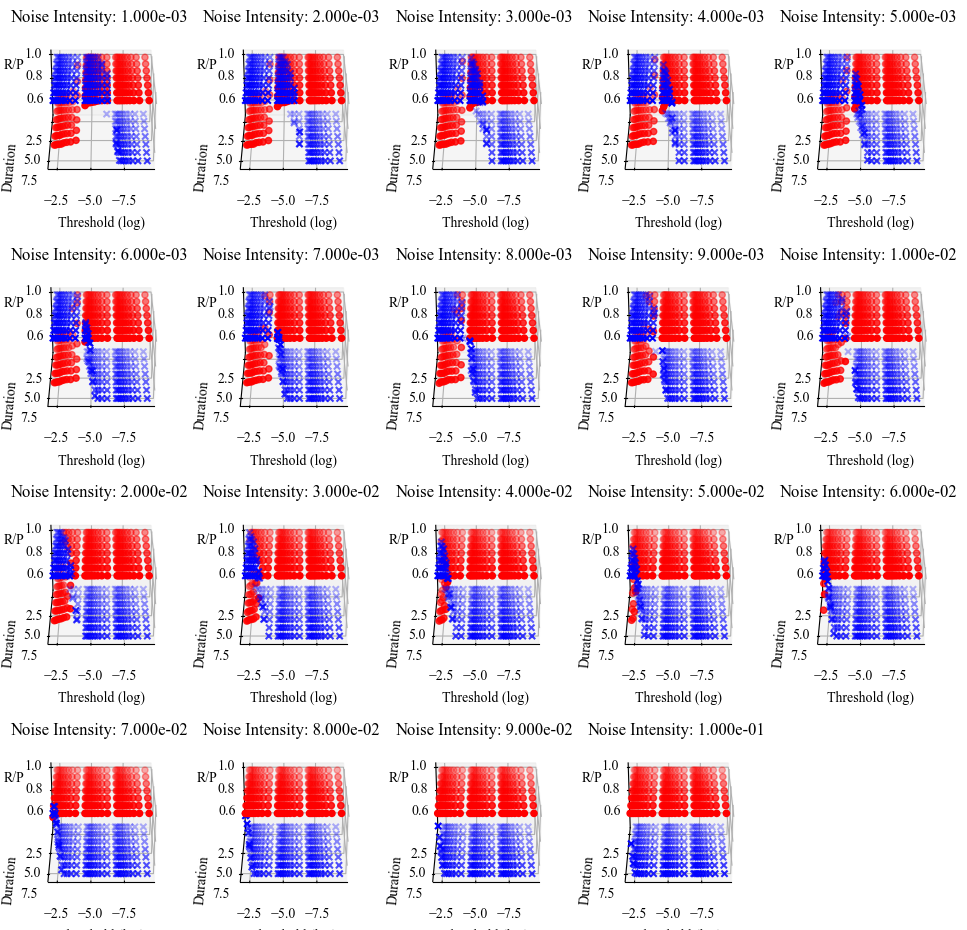

In [11]:
# visualization

# plot recall and precision in one subplot for each noise level

# load the data
noise_intensity = np.load('Noise_Intensity.npy')
threshold_vec = np.load('Threshold.npy')
duration_vec = np.load('Duration.npy')
Recall_Array = np.load('Recall_Array.npy')
Precision_Array = np.load('Precision_Array.npy')

# plot the data in 3d, USE 5 X 4 SUBPLOTS
fig = plt.figure(figsize=(12, 18))

for i in range(dim_noise):
    ax = fig.add_subplot(6, 5, i+1, projection='3d')
    
    # X, Y = np.meshgrid(threshold_vec, duration_vec)
    X, Y = np.meshgrid(np.log(threshold_vec), duration_vec)
    
    R = Recall_Array[i].T
    
    P = Precision_Array[i].T
    
    # USE SCATTER PLOT
    ax.scatter(X, Y, R, c='r', marker='o')
    ax.scatter(X, Y, P, c='b', marker='x')
    
    ax.set_xlabel('Threshold (log)')
    ax.set_ylabel('Duration')
    ax.set_zlabel('R/P')
    
    # control view angle
    ax.view_init(30, 90)

    ax.set_title('Noise Intensity: %.3e' % noise_intensity[i])
    
plt.show()

## save the figure
fig.savefig('Evaluation_Scatters.png')


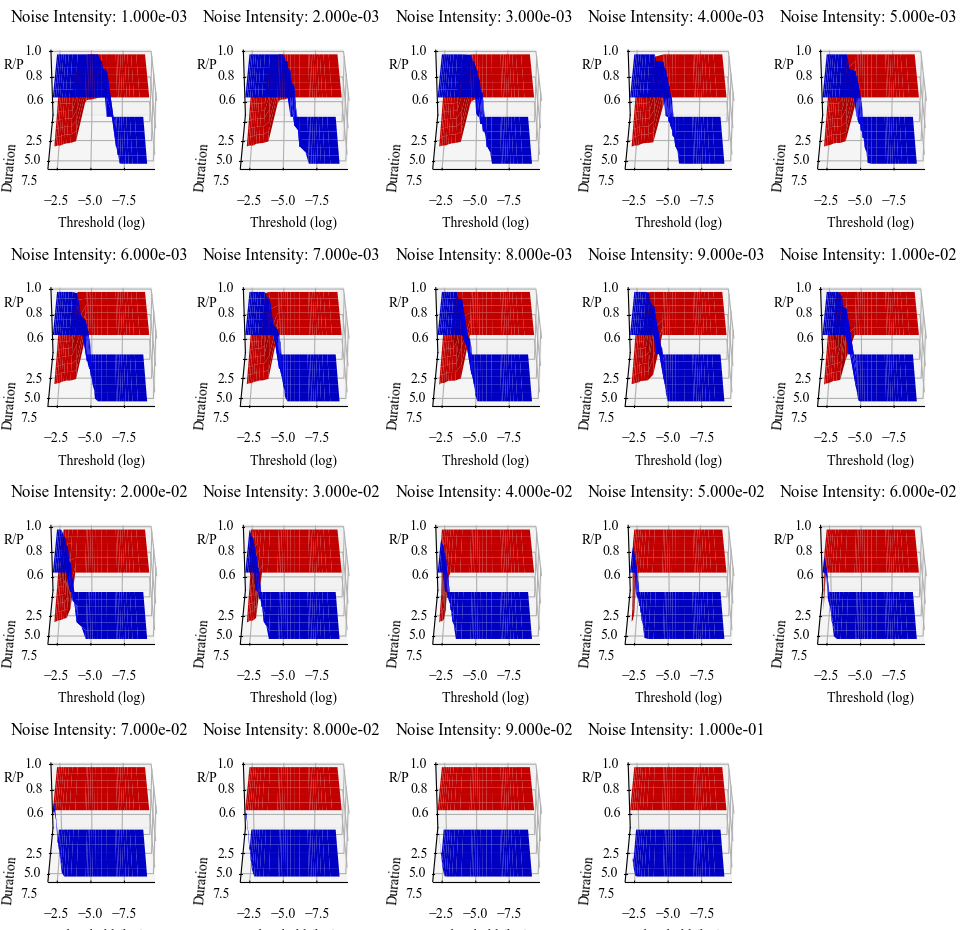

In [12]:
# visualization

# plot use surface plot, each noise level has a subplot, each plot contains two surfaces, one for recall, one for precision

# load the data
noise_intensity = np.load('Noise_Intensity.npy')
threshold_vec = np.load('Threshold.npy')
duration_vec = np.load('Duration.npy')
Recall_Array = np.load('Recall_Array.npy')
Precision_Array = np.load('Precision_Array.npy')

# plot the data in 3d, use 4 X 5 subplots

fig = plt.figure(figsize=(12, 18))

for i in range(dim_noise):
    ax = fig.add_subplot(6, 5, i+1, projection='3d')

    X, Y = np.meshgrid(np.log(threshold_vec), duration_vec)
    
    R = Recall_Array[i].reshape((threshold_num, duration_num)).T
    
    P = Precision_Array[i].reshape((threshold_num, duration_num)).T
    
    # USE SURFACE PLOT
    ax.plot_surface(X, Y, R, color='r')
    ax.plot_surface(X, Y, P, color='b')
    
    ax.set_xlabel('Threshold (log)')
    ax.set_ylabel('Duration')
    ax.set_zlabel('R/P')
    
    # control view angle
    ax.view_init(30, 90)
    
    ax.set_title('Noise Intensity: %.3e' % noise_intensity[i])

plt.show()

## save the figure
fig.savefig('Evaluation_Result_Surface.png')

## NN Training for Recall Prediction

### Data Preprocess

In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [14]:
# load the data
noise_intensity = np.load('Noise_Intensity.npy')
threshold_vec = np.load('Threshold.npy')
duration_vec = np.load('Duration.npy')
Recall_Array = np.load('Recall_Array.npy')
Precision_Array = np.load('Precision_Array.npy')

num_samples = dim_noise * threshold_num * duration_num

INPUT = np.zeros((num_samples, dim_Recall_Array))
OUTPUT_RECALL = np.zeros((num_samples, 1))

# generate the input and output data
for i in range(dim_noise):
    for j in range(threshold_num):
        for k in range(duration_num):
            idx = i * threshold_num * duration_num + j * duration_num + k
            INPUT[idx, 0] = noise_intensity[i]
            INPUT[idx, 1] = threshold_vec[j]
            INPUT[idx, 2] = duration_vec[k]
            OUTPUT_RECALL[idx, 0] = Recall_Array[i, j, k]
            

In [15]:
# split the data into training and testing

X_train_R, X_test_R, y_train_R, y_test_R = train_test_split(INPUT, OUTPUT_RECALL, test_size=0.2, random_state=43)

### Model Building

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import History

In [17]:
# build the model
mlp_model_recall = Sequential()
mlp_model_recall.add(Dense(16, input_dim=dim_Recall_Array, activation='relu'))
mlp_model_recall.add(Dense(8, activation='relu'))
mlp_model_recall.add(Dense(1, activation='relu'))



C:\Users\cswof\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
# compile the model
mlp_model_recall.compile(optimizer=Adam(), loss='mse')



In [19]:
# print the model summary
mlp_model_recall.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 209 (836.00 B)

 Trainable params: 209 (836.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
# record the training history
history = History()



In [21]:
# train the model
mlp_model_recall.fit(X_train_R, y_train_R, epochs=150, batch_size=32, callbacks=[history], validation_split=0.2)



Epoch 1/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1755 - val_loss: 0.1300
Epoch 2/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1126 - val_loss: 0.0975
Epoch 3/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0835 - val_loss: 0.0706
Epoch 4/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0611 - val_loss: 0.0365
Epoch 5/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0292 - val_loss: 0.0173
Epoch 6/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0157 - val_loss: 0.0123
Epoch 7/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0132 - val_loss: 0.0112
Epoch 8/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0118 - val_loss: 0.0107
Epoch 9/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113 - val_loss: 0.0107
Epoch 10/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0114 - val_loss: 0.0097
Epoch 11/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104 - val_loss: 0.0091
Epoch 12/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0

In [22]:
# test the model
y_pred_R = mlp_model_recall.predict(X_test_R)

# calculate the mse of the model
mse_R = mean_squared_error(y_test_R, y_pred_R)

print('MSE of Recall:', mse_R)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE of Recall: 0.007660266074647296


In [23]:
# save the model
mlp_model_recall.save('recall_est.keras')



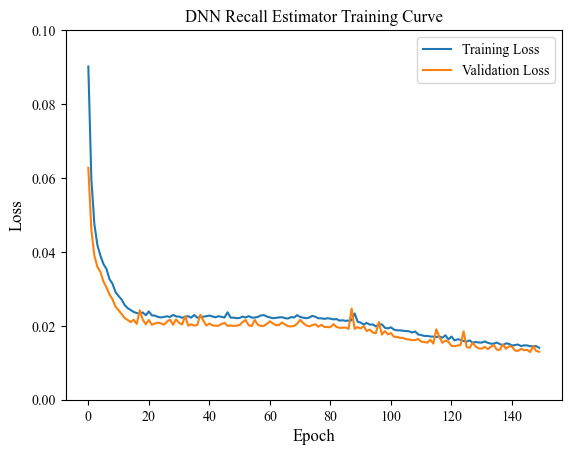

In [40]:
# plot the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('DNN Recall Estimator Training Curve')
plt.xlabel('Epoch', fontsize="large")
plt.ylabel('Loss', fontsize="large")
plt.legend(loc='upper right')

# set y limit to 0-1
plt.ylim(0, 0.1)

#save the figure
plt.savefig('DNN_Estimator.png')

plt.show()




## NN Training for Precision Prediction

In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [26]:
# load the data
noise_intensity = np.load('Noise_Intensity.npy')
threshold_vec = np.load('Threshold.npy')
duration_vec = np.load('Duration.npy')
Recall_Array = np.load('Recall_Array.npy')
Precision_Array = np.load('Precision_Array.npy')

num_samples = dim_noise * threshold_num * duration_num

INPUT = np.zeros((num_samples, dim_Recall_Array))
OUTPUT_PRECISION = np.zeros((num_samples, 1))

# generate the input and output data

for i in range(dim_noise):
    for j in range(threshold_num):
        for k in range(duration_num):
            idx = i * threshold_num * duration_num + j * duration_num + k
            INPUT[idx, 0] = noise_intensity[i]
            INPUT[idx, 1] = threshold_vec[j]
            INPUT[idx, 2] = duration_vec[k]
            OUTPUT_PRECISION[idx, 0] = Precision_Array[i, j, k]
            

In [27]:
# split the data into training and testing

X_train_P, X_test_P, y_train_P, y_test_P = train_test_split(INPUT, OUTPUT_PRECISION, test_size=0.2, random_state=42)

### Model Building

In [28]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import History

In [29]:
# build the model
mlp_model_precision = Sequential()
mlp_model_precision.add(Dense(16, input_dim=dim_Precision_Array, activation='relu'))
mlp_model_precision.add(Dense(8, activation='relu'))
mlp_model_precision.add(Dense(1))

C:\Users\cswof\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
# compile the model
mlp_model_precision.compile(optimizer=Adam(), loss='mse')

In [31]:
# print the model summary
mlp_model_precision.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 209 (836.00 B)

 Trainable params: 209 (836.00 B)

 Non-trainable params: 0 (0.00 B)

In [32]:
# record the training history
history = History()

In [33]:
# train the model
mlp_model_precision.fit(X_train_P, y_train_P, epochs=150, batch_size=32, callbacks=[history], validation_split=0.2)

Epoch 1/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1129 - val_loss: 0.0627
Epoch 2/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0640 - val_loss: 0.0460
Epoch 3/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0516 - val_loss: 0.0390
Epoch 4/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0440 - val_loss: 0.0359
Epoch 5/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0387 - val_loss: 0.0346
Epoch 6/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0388 - val_loss: 0.0320
Epoch 7/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0355 - val_loss: 0.0304
Epoch 8/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0334 - val_loss: 0.0285
Epoch 9/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0328 - val_loss: 0.0272
Epoch 10/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0304 - val_loss: 0.0251
Epoch 11/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0291 - val_loss: 0.0242
Epoch 12/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0

In [34]:
# test the model
y_pred_P = mlp_model_precision.predict(X_test_P)

# calculate the mse of the model
mse_P = mean_squared_error(y_test_P, y_pred_P)

print('MSE of Precision:', mse_P)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE of Precision: 0.01371891121648037


In [35]:
# save the model
mlp_model_precision.save('precision_est.keras')

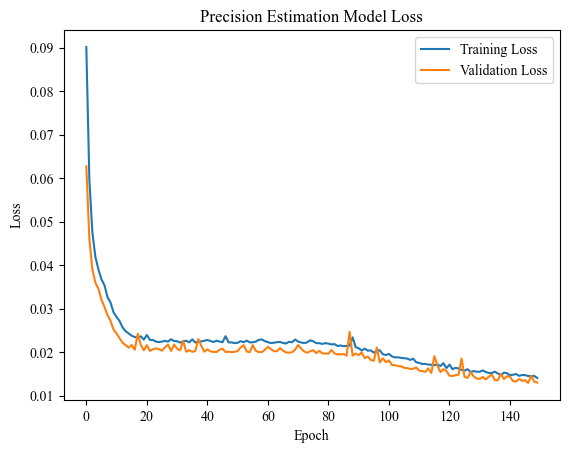

In [36]:
# plot the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Precision Estimation Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

#save the figure
plt.savefig('Training_History_Precision.png')

plt.show()

